In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
from time import time
from scipy.optimize import fmin_powell
from scipy import integrate
import theano as thno
import theano.tensor as T

In [2]:
# importing the dataset

In [6]:
df = pd.read_csv('assignment_clean_up.csv')

In [7]:
df.head()

,Retailer,Salerank,X2013USSales,X2013WorldSales,ProfitMargin,NumStores,Industry,Reward,ProgramName,RewardType,RewardStructure,RewardSize,ExpirationMonth,IndustryType
0,A&P,74,5.831,5.831,48.85,0.277,"Discount, Variety Stores",0,No rewards program,-,-,-,-,Discount
1,Albertsons,21,19.452,19.452,69.02,1.024,Grocery Stores,0,No rewards program,-,-,-,-,Grocery
2,Aldi,38,10.898,10.650,69.41,1.328,Grocery Stores,0,No rewards program,-,-,-,-,Grocery
3,Alimentation Couche Tard (Circle K),82,4.755,8.551,68.03,3.826,Grocery Stores,0,No rewards program,-,-,-,-,Grocery
4,Apple Stores,15,26.648,30.736,11.07,0.254,ElectronicEquipment,0,No rewards program,-,-,-,-,Specialty


In [8]:
# Feature engineering
df.columns

Index(['Retailer', 'Salerank', 'X2013USSales', 'X2013WorldSales',
       'ProfitMargin', 'NumStores', 'Industry', 'Reward', 'ProgramName',
       'RewardType', 'RewardStructure', 'RewardSize', 'ExpirationMonth',
       'IndustryType'],
      dtype='object')

In [10]:
df.Reward.unique()

array([0, 1])

In [11]:
df.IndustryType.unique()

array(['Discount', 'Grocery', 'Specialty', 'Restaurants', 'Department'],
      dtype=object)

In [12]:
data = pd.get_dummies(df.IndustryType)

In [14]:
data['Reward'] = df.Reward

In [34]:
# adding salesrank and ProfitMargin for more meaningful analysis
data['ProfitMargin'] = df.ProfitMargin
data['Salerank'] = df.Salerank

## Logistic regression model
### Model specification
prior on $\beta$ vector. A very uninformative prior
$$P(\beta) \sim N(0,10^{12})$$ 
likelihood of the data given the parameters
$$y \sim bern(p = \frac{1}{1+e^{-X^T \beta}})$$
$$P(y,X|\beta) = \frac{1}{1+e^{-X^T \beta}}(1-\frac{1}{1+e^{-X^T \beta}})^{(1-y)}$$
Of interest is the posterior
$$P(\beta|y,X) \propto P(y,X|\beta)P(\beta)$$

In [15]:
# fitting the model
with pm.Model() as model:
    pm.GLM.from_formula('Reward~Grocery+Restaurants',data)
    trace = pm.sample(2000, init ='advi',progressbar = True)
    posterior_predictive = pm.sample_posterior_predictive(trace)
trace = trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 12100
Interrupted at 12,099 [6%]: Average Loss = 134.46
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, Restaurants, Grocery, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.


In [16]:
# Model results
trace.varnames

['Intercept', 'Grocery', 'Restaurants', 'sd_log__', 'sd']

<Figure size 648x504 with 0 Axes>

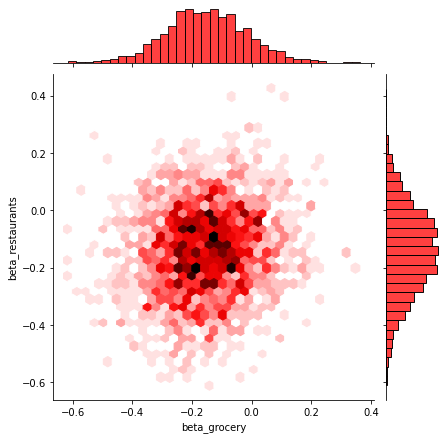

In [20]:
#Plotting the joint distribution of the intercepts
#Showing how the model paramenters are distributed. Not correlated (Typically what we want for our model)
plt.figure(figsize=(9,7))
seaborn.jointplot(trace['Grocery'],trace['Restaurants'],kind='hex',color='red')
plt.xlabel('beta_grocery')
plt.ylabel('beta_restaurants')
plt.show()

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

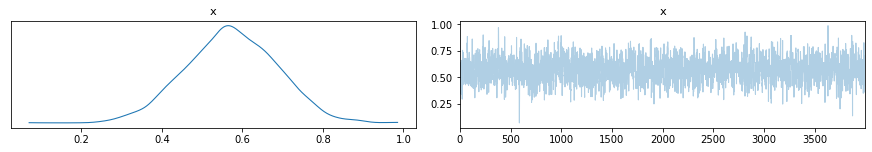

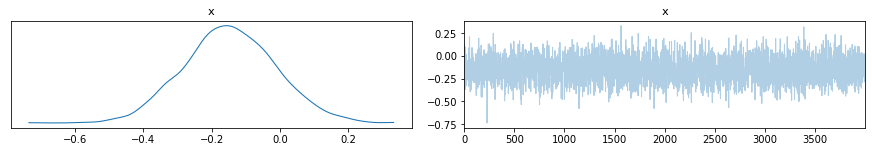

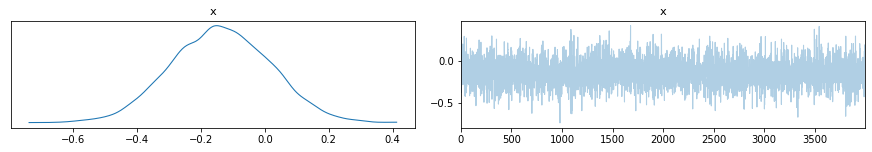

In [45]:
pm.traceplot(trace['Intercept'])
pm.traceplot(trace['Grocery'])
pm.traceplot(trace['Restaurants'])

In [46]:
# getting the posterior predictive distributions of the model
# over all Grocery types for Restaurants that received a give (This has no real world meaning)
# Just showing the sort of things that can be done as an analysis
lm = lambda x, samples:(1/(1+np.exp(-(samples['Intercept'] + 
                                   samples['Grocery']*x +
                                   samples['Restaurants']*0))))

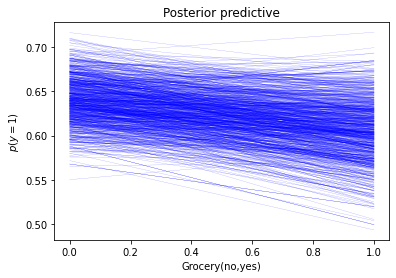

In [49]:
# Plotting the posterior predictive distribution (neither does the plot carry any particular meaning)
pm.plot_posterior_predictive_glm(trace,eval = np.array([0,1],dtype=int),lm=lm,samples=1000,color="blue",alpha=.5)
plt.xlabel('Grocery(no,yes)')
plt.ylabel('$p(y=1)$')
plt.show()

In [35]:
# Fitting a more meaning model after test run
# fitting the model
with pm.Model() as model:
    pm.GLM.from_formula('Reward~Grocery+Salerank+Restaurants',data)
    trace = pm.sample(2000, init ='advi',progressbar = True)
    posterior_predictive = pm.sample_posterior_predictive(trace)
trace1 = trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 35600
Interrupted at 35,599 [17%]: Average Loss = 9,299.1
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, Restaurants, Salerank, Grocery, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.


<Figure size 648x504 with 0 Axes>

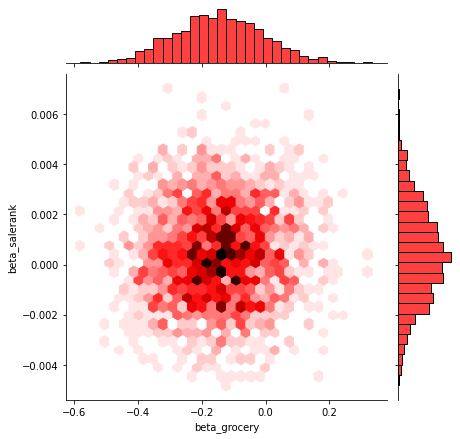

In [50]:
#Plotting the joint distribution of the intercepts
#Showing how the model paramenters are distributed. Not correlated (Typically what we want for our model)
# Notice also that most of the mass is centered around zero and therefore the betas might not be 
# statistically significantly different from 0
plt.figure(figsize=(9,7))
seaborn.jointplot(trace1['Grocery'],trace1['Salerank'],kind='hex',color='red')
plt.xlabel('beta_grocery')
plt.ylabel('beta_salerank')
plt.show()

<Figure size 648x504 with 0 Axes>

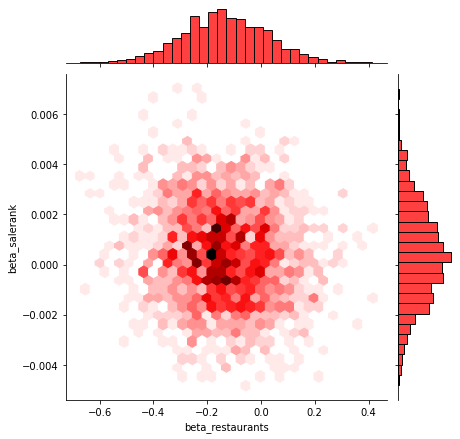

In [38]:
#Plotting the joint distribution of the intercepts
#Showing how the model paramenters are distributed. Not correlated (Typically what we want for our model)
# Notice also that most of the mass is centered around zero and therefore the betas might not be 
# statistically significantly different from 0
plt.figure(figsize=(9,7))
seaborn.jointplot(trace1['Restaurants'],trace1['Salerank'],kind='hex',color='red')
plt.xlabel('beta_restaurants')
plt.ylabel('beta_salerank')
plt.show()

In [39]:
data.describe()

,Department,Discount,Grocery,Restaurants,Specialty,Reward,ProfitMargin,Salerank
count,100.00000,100.000000,100.000000,100.000000,100.00000,100.00,100.00000,100.000000
mean,0.08000,0.180000,0.180000,0.130000,0.43000,0.55,45.27300,50.500000
std,0.27266,0.386123,0.386123,0.337998,0.49757,0.50,29.23139,29.011492
min,0.00000,0.000000,0.000000,0.000000,0.00000,0.00,1.02000,1.000000
25%,0.00000,0.000000,0.000000,0.000000,0.00000,0.00,19.44500,25.750000
50%,0.00000,0.000000,0.000000,0.000000,0.00000,1.00,42.02000,50.500000
75%,0.00000,0.000000,0.000000,0.000000,1.00000,1.00,69.57250,75.250000
max,1.00000,1.000000,1.000000,1.000000,1.00000,1.00,99.20000,100.000000


In [40]:
#Defining posterior predictive model
lm1 = lambda x, samples:(1/(1+np.exp(-(samples['Intercept'] + 
                                   samples['Grocery']*1 +
                                   samples['Salerank']*x +
                                   samples['Restaurants']*0))))

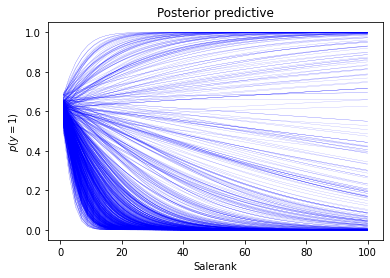

In [51]:
# plotting the posterior predictive distribution. probability of receiving award for grocery stores
# over different salerank. Does sale rank affect how groceries get rewarded?
# Plotting the posterior predictive distribution (neither does the plot carry any particular meaning)
pm.plot_posterior_predictive_glm(trace,eval = np.linspace(1,100,dtype=int),lm=lm,samples=1000,color="blue",alpha=.5)
plt.xlabel('Salerank')
plt.ylabel('$p(y=1)$')
plt.show()
# Notice how the instability of the coefficients leads to unclear outcomes.

In [53]:
# plotting the odds ration
b = trace1['Reward']
plt.hist(np.exp(b),bins = 25,normed=True)
plt.xlabel('Odds Ratio')

KeyError: 'Unknown variable Reward'